# Principal Component Analysis

## References

https://www.kaggle.com/datasets/sadeghjalalian/wine-customer-segmentation

## Import Python Libraries

In [420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [421]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black
c6 = ["#fbfce6", "#a2daf2", "#ffc7c7"]
c7 = [(0, 0, 1), (0, 1 ,0), (1, 0, 0)]

## Import Dataset

In [422]:
# Source: https://www.kaggle.com/datasets/sadeghjalalian/wine-customer-segmentation

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Alcohol
# X02: Malic_Acid
# X03: Ash
# X04: Ash_Alcanity
# X05: Magnesium
# X06: Total_Phenols
# X07: Flavanoids
# X08: Nonflavanoid_Phenols
# X09: Proanthocyanins
# X10: Color_Intensity
# X11: Hue
# X12: OD280
# X13: Proline
#   y: Customer_Segment [1-3]

In [423]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/wine_segmentation.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [424]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'Customer_Segment'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [425]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.y = df1.y.astype('str')

df1.head()


,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [426]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     178 non-null    float64
 1   X02     178 non-null    float64
 2   X03     178 non-null    float64
 3   X04     178 non-null    float64
 4   X05     178 non-null    int64  
 5   X06     178 non-null    float64
 6   X07     178 non-null    float64
 7   X08     178 non-null    float64
 8   X09     178 non-null    float64
 9   X10     178 non-null    float64
 10  X11     178 non-null    float64
 11  X12     178 non-null    float64
 12  X13     178 non-null    int64  
 13  y       178 non-null    object 
dtypes: float64(11), int64(2), object(1)
memory usage: 19.6+ KB


In [427]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [428]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
y      0
dtype: int64

## Data Cleaning and Transformation

In [429]:
# response column
y_col = new_y_col
y_col

'y'

In [430]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13'],
      dtype='object')

In [431]:
# get unique y_labels
y_labels = np.sort(df1[y_col].unique())
# y_labels = {y_labels[i]: i for i in range(len(y_labels))}
y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{0: '1', 1: '2', 2: '3'}

In [432]:
# rename y_labels
df1[y_col] = df1[y_col].replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [433]:
# # check label distribution
# temp_labels = list(y_labels.values())
# cond_list = []
# count_list = []
# for i in np.arange(len(temp_labels)):
#   # condition for rows matching response label
#   # print(i)
#   x = temp_labels[i]
#   temp_cond = list(df1[y_col] == x)
#   cond_list.append(temp_cond)
#   # print(cond_list)
#   # get total label count
#   temp_n = np.sum(cond_list[i])
#   # print(temp_n)
#   count_list.append(temp_n)
  
# # max label count
# n_max = np.max(count_list)
# # index where max value occurs
# i_max = np.where(count_list == n_max)[0][0]
# # index where max value does not occurs
# i_notmax = np.where(count_list != n_max)[0]

# print(temp_labels)
# print(count_list)
# print(n_max)
# print(i_max)
# print(i_notmax)

In [434]:
# # upsample minority labels
# df_upsample_list = []
# for i in i_notmax:
#   # print(i)
#   # get dataframe rows where label exsists
#   cond = cond_list[i]
#   # print(cond)
#   df_temp = df1.iloc[cond,:]
#   # print(df_temp.info())
  
#   # determine amount to upsample 
#   n_diff = n_max - count_list[i]
#   # print(n_diff)
  
#   # generate upsample dataframe 
#   df_upsample_temp = resample(
#     df_temp,
#     replace = True,
#     n_samples = n_diff,
#     random_state = random_state
#   )
#   df_upsample_list.append(df_upsample_temp)

# # put all dataframes in df_upsample_list into one
# df_upsample_list = pd.concat(df_upsample_list, ignore_index = True)

# # update df1 with upsampled dataframe
# df1 = pd.concat([df1, df_upsample_list], ignore_index = True)
# df1.info()

In [435]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
# df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [436]:
# update df1
X = df1[X_cols]
y = df1[y_col]
df1 = pd.concat([X, y], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     178 non-null    float64
 1   X02     178 non-null    float64
 2   X03     178 non-null    float64
 3   X04     178 non-null    float64
 4   X05     178 non-null    int64  
 5   X06     178 non-null    float64
 6   X07     178 non-null    float64
 7   X08     178 non-null    float64
 8   X09     178 non-null    float64
 9   X10     178 non-null    float64
 10  X11     178 non-null    float64
 11  X12     178 non-null    float64
 12  X13     178 non-null    int64  
 13  y       178 non-null    object 
dtypes: float64(11), int64(2), object(1)
memory usage: 19.6+ KB


In [437]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,1
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,1
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,1
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,1
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,1


In [438]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

## Visualize Dataset

In [439]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (15, 15)

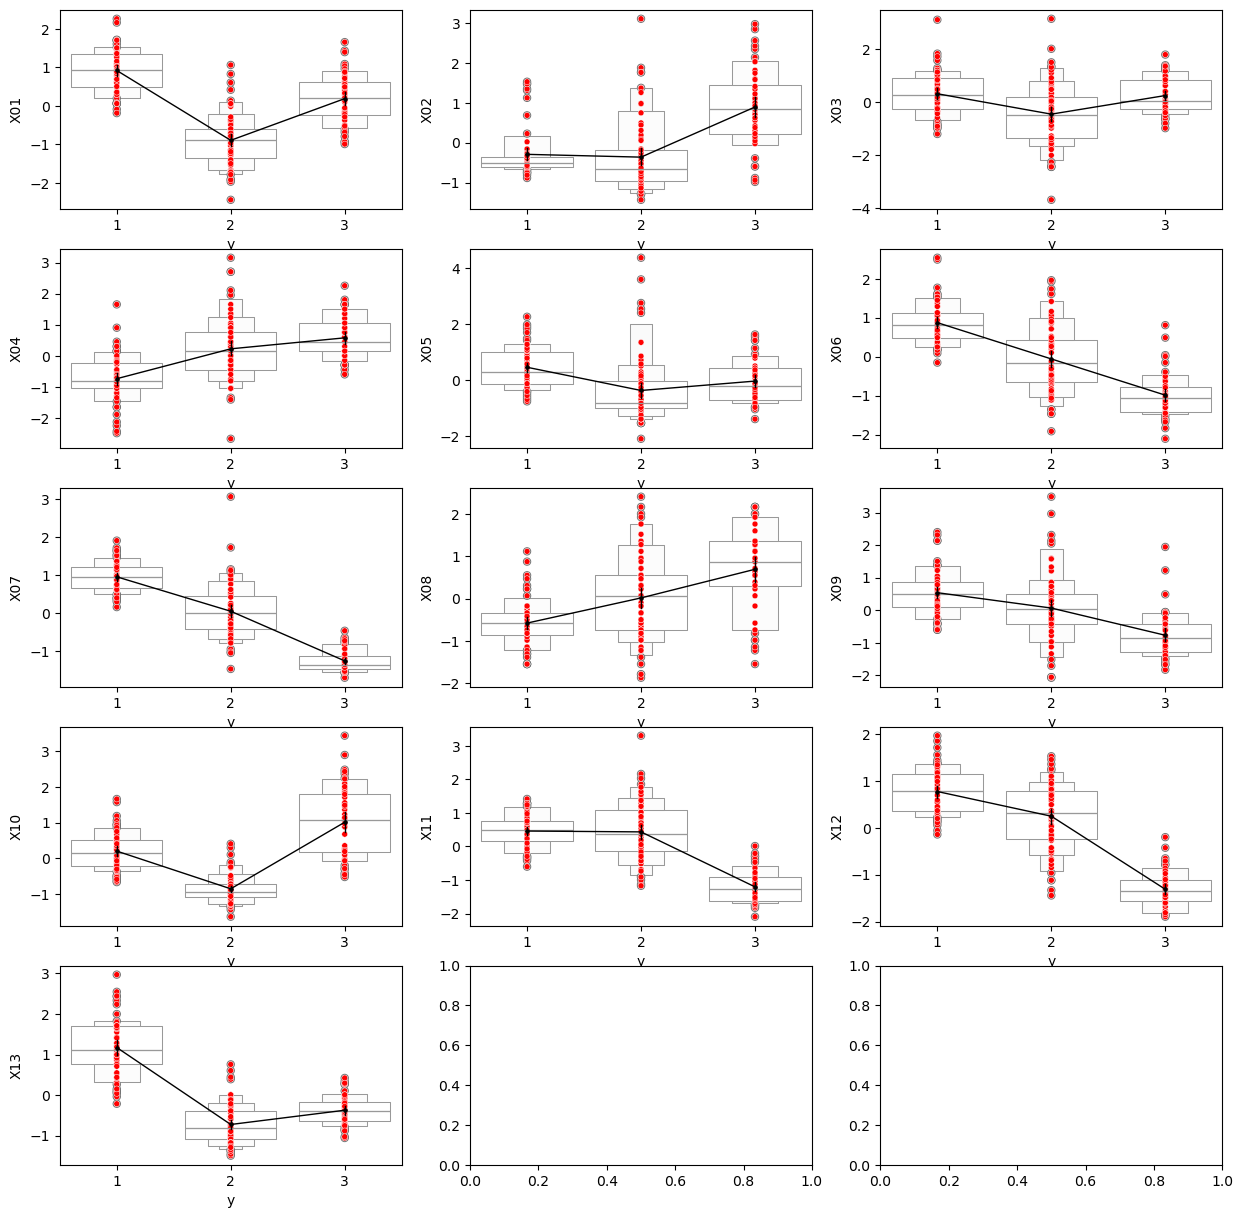

In [440]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.scatterplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Train and Test ML Model

In [441]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [442]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
  stratify = y, shuffle = True, 
  train_size = 0.8, random_state = random_state
)

In [443]:
# get principal components
pca = PCA(n_components = 2)

In [444]:
# fit principal components to training data
temp = pca.fit(X_train, y_train)

In [445]:
# pca explained variance ration
var_ratio = pca.explained_variance_ratio_
var_ratio.sum()

0.5584144567934777

In [446]:
# transform data based on principal components
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [447]:
# initialize LogisticRegression model
myfit = LogisticRegression(
  fit_intercept = True,
  tol = 1E-15,
  random_state = random_state
)

In [448]:
# fit model
temp = myfit.fit(X_train, y_train)

In [449]:
# get predictions on test data
y_hat = myfit.predict(X_test)

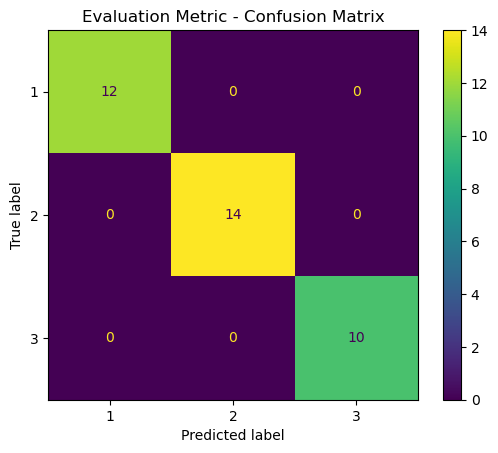

In [450]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [451]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [452]:
# function for plotting segments
def jra_plot_segments(X, y, classifier_fit, colors_contour, colors_scatter, title):
  X_values, y_values = X, y
  X1_min = X_values[:,0].min() - 1
  X2_min = X_values[:,1].min() - 1
  X2_max = X_values[:,1].max() + 1
  X1_max = X_values[:,0].max() + 1
  X1_values = np.arange(X1_min, X1_max, 0.01)
  X2_values = np.arange(X2_min, X2_max, 0.01)

  X1, X2 = np.meshgrid(X1_values, X2_values)

  X_fill = np.array([X1.ravel(), X2.ravel()]).T
  y_hat_fill = classifier_fit.predict(X_fill).reshape(X1.shape)
  y_hat_fill

  # plot labels
  for i, j in enumerate(np.unique(y_values)):
    plt.scatter(
      X_values[y_values == j, 0], 
      X_values[y_values == j, 1],
      color = colors_scatter[i],
      label = j
    )
  
  # plot segemented regions
  plt.contourf(X1, X2, y_hat_fill.astype('float'), 
    alpha = 0.5,
    cmap = ListedColormap(colors_contour)  # https://matplotlib.org/stable/users/explain/colors/colormaps.html
  )
  
  # clean up plot
  plt.xlim(X1_min, X1_max)
  plt.ylim(X2_min, X2_max)
  plt.title(title)
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  # plt.show()

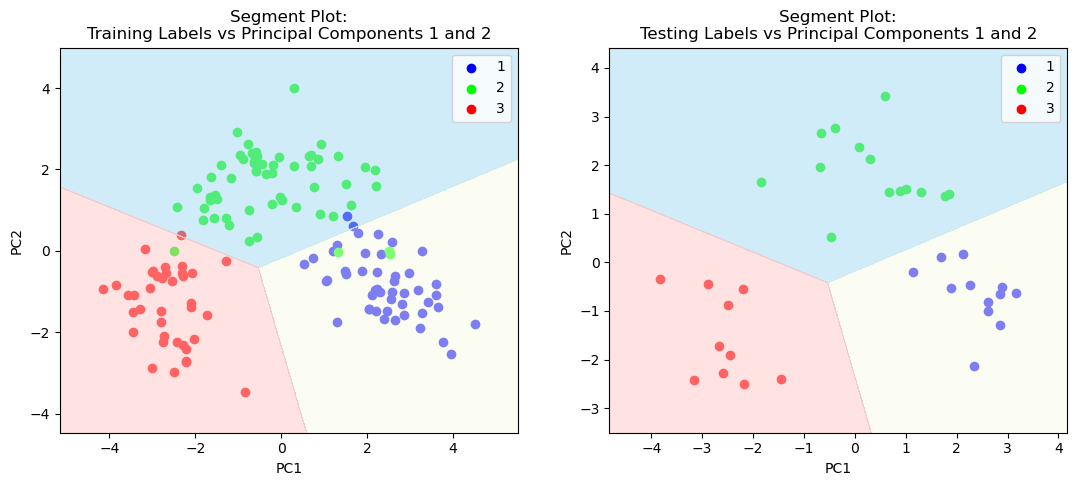

In [453]:
# plot segments for train + test dataset
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,5))
plt.subplot(121)
jra_plot_segments(
  X = X_train, y = y_train, 
  classifier_fit = myfit, 
  colors_contour = c6, colors_scatter = c7,
  title = 'Segment Plot:\nTraining Labels vs Principal Components 1 and 2'
)
plt.subplot(122)
jra_plot_segments(
  X = X_test, y = y_test, 
  classifier_fit = myfit, 
  colors_contour = c6, colors_scatter = c7,
  title = 'Segment Plot:\nTesting Labels vs Principal Components 1 and 2'
)

plt.show()